In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [7]:
# --- VISUAL STYLE CONFIGURATION ---
plt.style.use('dark_background')
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['axes.facecolor'] = '#0e0e0e'
plt.rcParams['figure.facecolor'] = '#0e0e0e'
plt.rcParams['text.color'] = '#e0e0e0'
plt.rcParams['axes.labelcolor'] = '#e0e0e0'
plt.rcParams['xtick.color'] = '#a0a0a0'
plt.rcParams['ytick.color'] = '#a0a0a0'

In [8]:
def get_market_data(ticker, start_date, end_date):
    """
    Downloads historical data for the specified ticker.
    """
    print(f"Downloading data for {ticker}...")
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)

    # Fix for multi-level columns in newer yfinance versions
    if isinstance(df.columns, pd.MultiIndex):
        try:
            df = df.xs(key='Close', axis=1, level='Price')
        except KeyError:
            # Fallback if structure is different
            df = df['Close']
    else:
        # Standard structure
        df = df[['Close']] if 'Close' in df.columns else df

    df.columns = ['Close']
    return df

In [9]:
def calculate_ergodicity_metrics(df, rolling_window=252):
    """
    Calculates log returns, the long-term expanding mean,
    and the short-term rolling mean to identify regimes.
    """
    # 1. Logarithmic Returns: ln(Pt / Pt-1)
    # We use log returns because they are additive over time.
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # 2. Spatial Mean (Expanding): The "Global Average"
    # This represents the long-term memory of the asset since the start date.
    df['Expanding_Mean'] = df['Log_Return'].expanding().mean()

    # 3. Temporal Mean (Rolling): The "Local Behavior"
    # This represents what the market is doing right now (short term).
    df['Rolling_Mean'] = df['Log_Return'].rolling(window=rolling_window).mean()

    # 4. The Spread (Difference)
    # Measures how far the current behavior deviates from the historical norm.
    df['Diff'] = df['Rolling_Mean'] - df['Expanding_Mean']

    return df.dropna()

In [10]:
def plot_ergodicity_dashboard(df, ticker, threshold_sigma=1.0):
    """
    Plots the price, the comparison of means, and the distribution histogram.
    """
    # --- STATISTICS ---
    # Calculate thresholds based on the standard deviation of the Difference
    mu_diff = df['Diff'].mean()
    sigma_diff = df['Diff'].std()

    upper_thresh = mu_diff + (threshold_sigma * sigma_diff)
    lower_thresh = mu_diff - (threshold_sigma * sigma_diff)

    # Identify Non-Ergodic events (when the difference is outside the bands)
    df['Non_Ergodic'] = (df['Diff'] > upper_thresh) | (df['Diff'] < lower_thresh)

    # Calculate current state
    current_state = "NON-ERGODIC" if df['Non_Ergodic'].iloc[-1] else "ERGODIC"
    state_color = "red" if df['Non_Ergodic'].iloc[-1] else "#00ff00" # Green

    # --- PLOTTING ---
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1.5, 1], hspace=0.3)

    # 1. PRICE CHART (Log Scale)
    ax1 = plt.subplot(gs[0])
    ax1.plot(df.index, df['Close'], color='white', lw=1, alpha=0.7, label='Price')
    ax1.set_yscale('log')

    # Highlight Non-Ergodic moments with red dots
    non_ergodic_events = df[df['Non_Ergodic']]
    ax1.scatter(non_ergodic_events.index, non_ergodic_events['Close'],
                color='orangered', s=10, label='Non-Ergodic Events', zorder=5)

    ax1.set_title(f"{ticker} Price (Log) | Current State: {current_state}",
                  fontsize=14, color='white', fontweight='bold')
    ax1.legend(loc='upper left')

    # 2. MEANS COMPARISON
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax2.plot(df.index, df['Expanding_Mean'], color='orange', ls=':', lw=1.5, label='Spatial Mean (Expanding)')
    ax2.plot(df.index, df['Rolling_Mean'], color='cyan', lw=1.2, label='Temporal Mean (Rolling)')

    # Visualize the "Allowed Band" (This is an approximation for visual aid)
    # We project the threshold band around the Expanding Mean
    ax2.fill_between(df.index,
                     df['Expanding_Mean'] + (threshold_sigma * sigma_diff),
                     df['Expanding_Mean'] - (threshold_sigma * sigma_diff),
                     color='green', alpha=0.1, label='Ergodic Zone')

    ax2.set_title("Short-term vs Long-term Mean Returns", fontsize=12)
    ax2.legend(loc='upper left')

    # 3. DISTRIBUTION HISTOGRAM
    ax3 = plt.subplot(gs[2])
    ax3.hist(df['Diff'], bins=80, color='#30699c', edgecolor='#0e0e0e', alpha=0.8)

    # Draw vertical threshold lines
    ax3.axvline(upper_thresh, color='orangered', ls='--', label=f'+{threshold_sigma}σ')
    ax3.axvline(lower_thresh, color='orangered', ls='--', label=f'-{threshold_sigma}σ')

    ax3.set_title("Distribution of the Difference (Rolling - Expanding)", fontsize=12)
    ax3.legend()

    plt.show()

/tmp/ipython-input-2037814928.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-2384871502.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Non_Ergodic'] = (df['Diff'] > upper_thresh) | (df['Diff'] < lower_thresh)


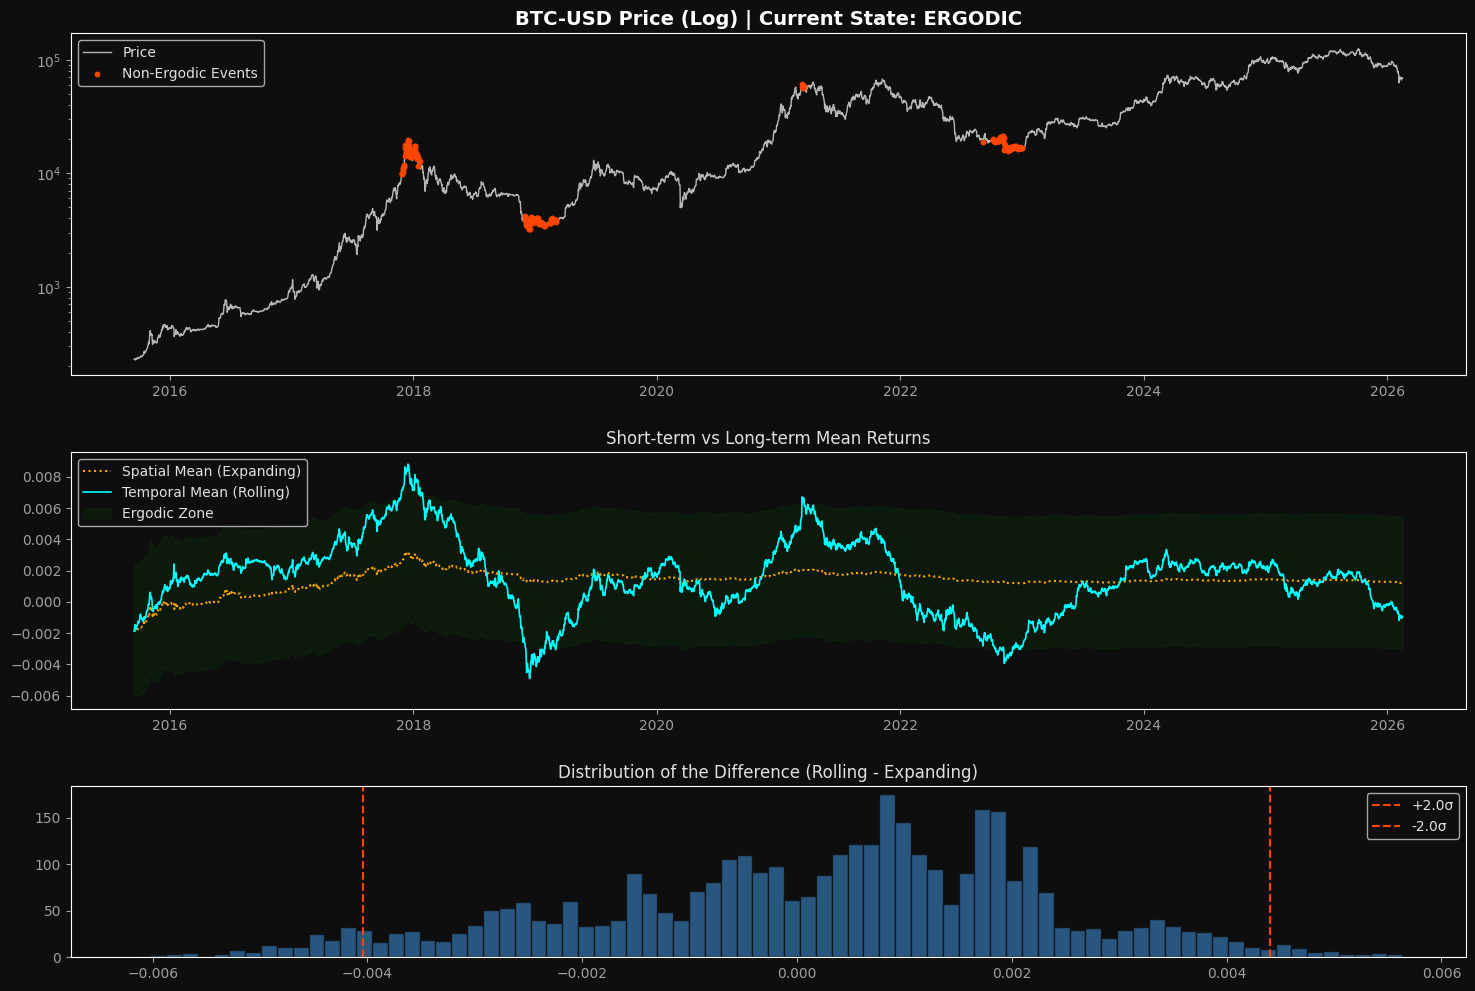

In [14]:
if __name__ == "__main__":
    # Parameters
    TICKER = "BTC-USD"
    START = "2010-01-01"
    END = "2026-02-16"
    WINDOW = 365       # 1 Year Rolling Window
    THRESHOLD = 2.0    # 1 Sigma Threshold

    # Run Pipeline
    data = get_market_data(TICKER, START, END)

    if len(data) > WINDOW:
        processed_data = calculate_ergodicity_metrics(data, rolling_window=WINDOW)
        plot_ergodicity_dashboard(processed_data, TICKER, threshold_sigma=THRESHOLD)
    else:
        print("Not enough data for calculation.")